# Set-Up

In [2]:
# Install Requirements

!pip install -r requirements.txt

In [4]:
# Import packages 

import os
import numpy as np
from torch.utils.data import Dataset
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import random
import rasterio
import numpy as np
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [5]:
# Set device to CUDA if available, then MPS, then fall back to CPU

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [ ]:
# Set directories

s2_dir = "/Users/tessacannon/Documents/UCL/Dissertation/s2_patches"
lidar_dir = "/Users/tessacannon/Documents/UCL/Dissertation/lidar_patches"

# Data Transformations

In [ ]:
# Compute Sentinel-2 mean and standard deviation by channel to normalize the images

def compute_s2_mean_std(s2_dir):
    """
    Computes the per-channel mean and standard deviation for Sentinel-2 image patches in a directory.

    Args:
        s2_dir (str): Path to the directory containing Sentinel-2 .tif files (expected shape: [4, H, W]).

    Returns:
        mean (torch.Tensor): Tensor of shape (4,) containing the mean for each channel.
        std (torch.Tensor): Tensor of shape (4,) containing the standard deviation for each channel.
    """
    s2_paths = sorted(glob.glob(os.path.join(s2_dir, "s2_patch_*.tif")))

    sum_vals = torch.zeros(4)
    sum_sq_vals = torch.zeros(4)
    pixel_count = 0

    # Loop through S2 tif files
    for path in tqdm(s2_paths, desc="Computing S2 stats"):
        with rasterio.open(path) as src:
            arr = torch.from_numpy(src.read().astype(np.float32))  # (4, H, W)
        arr = arr.view(4, -1)
        sum_vals += arr.sum(dim=1)
        sum_sq_vals += (arr ** 2).sum(dim=1)
        pixel_count += arr.shape[1]

    mean = sum_vals / pixel_count
    std = torch.sqrt(sum_sq_vals / pixel_count - mean ** 2)
    return mean, std

mean, std = compute_s2_mean_std(s2_dir) 
print("S2 Mean:", mean)
print("S2 Std:", std)

Computing S2 stats: 100%|██████████| 4437/4437 [00:05<00:00, 832.91it/s]


S2 Mean: tensor([10445.0703, 10330.9932, 10378.2959, 10169.0459])
S2 Std: tensor([160.5491, 147.8918, 131.6966, 157.3023])


In [ ]:
# Define dataset class (includes transformations and data augmentation)

class LidarS2Dataset(Dataset):
    def __init__(self, lidar_dir, s2_dir, s2_means, s2_stds, augment=True):
        self.lidar_paths = sorted(glob.glob(os.path.join(lidar_dir, "lidar_patch_*.tif")))
        self.s2_paths = sorted(glob.glob(os.path.join(s2_dir, "s2_patch_*.tif")))
        self.augment = augment
        self.s2_mean = s2_means
        self.s2_std = s2_stds

        # Ensure there are the same number of LiDAR and S2 files
        assert len(self.lidar_paths) == len(self.s2_paths), "Mismatch between LiDAR and S2 patch counts"

    def __len__(self):
        return len(self.lidar_paths)

    def __getitem__(self, idx):
        # Read data file paths at the given index
        lidar = self.read_tif(self.lidar_paths[idx])  # (3, H, W)
        s2 = self.read_tif(self.s2_paths[idx])        # (4, H, W)

        # Normalize Sentinel-2
        s2 = (s2 - self.s2_mean[:, None, None]) / self.s2_std[:, None, None]

        # Data augmentation: horizontal flips, vertical flips, and random rotations with 50% probability 
        if self.augment:
            if random.random() > 0.5:
                lidar = TF.hflip(lidar)
                s2 = TF.hflip(s2)
            if random.random() > 0.5:
                lidar = TF.vflip(lidar)
                s2 = TF.vflip(s2)
            if random.random() > 0.5:
                angle = random.choice([90, 180, 270])
                lidar = TF.rotate(lidar, angle)
                s2 = TF.rotate(s2, angle)

        # Return dictionary with the S2, LiDAR, and LiDAR mask separated
        return {
            "s2": s2.float(),              # [4, H, W]
            "lidar": lidar[:2].float(),    # [2, H, W]
            "mask": lidar[2].float()       # [H, W]
        }

    def read_tif(self, path):
        # Read tif file and convert it to float tensor 
        with rasterio.open(path) as src:
            arr = src.read()  # shape: (bands, H, W)
        return torch.from_numpy(arr.astype(np.float32))

# Model Development

In [ ]:
# Define model architecture 

# ==== EMBEDDING ====
def timestep_embedding(timesteps, dim):
    """
    Generates sinusoidal timestep embeddings for diffusion modeling.

    Args:
        timesteps (torch.Tensor): 1D tensor of time step indices (shape: [batch_size]).
        dim (int): Dimension of the embedding vector.

    Returns:
        torch.Tensor: Sinusoidal embeddings of shape [batch_size, dim], encoding each timestep as a vector.
    """
    device = timesteps.device
    half_dim = dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = timesteps[:, None].float() * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0, 1, 0, 0))
    return emb

# ==== MODEL BLOCKS ====

# Self Attention Block
class SelfAttention2D(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
        self.scale = channels ** -0.5

    def forward(self, x):
        B, C, H, W = x.shape
        q = self.q(x).flatten(2).permute(0, 2, 1)    # B, HW, C
        k = self.k(x).flatten(2)                     # B, C, HW
        v = self.v(x).flatten(2).permute(0, 2, 1)    # B, HW, C

        attn = torch.bmm(q, k) * self.scale          # B, HW, HW
        attn = torch.softmax(attn, dim=-1)

        out = torch.bmm(attn, v)                     # B, HW, C
        out = out.permute(0, 2, 1).view(B, C, H, W)
        return self.proj(out + x)

# Convolution Block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim, use_attention=False):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.GELU(),
        )
        self.time_embed = nn.Sequential(
            nn.Linear(embed_dim, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels)
        )
        self.attn = SelfAttention2D(out_channels) if use_attention else None

    def forward(self, x, t):
        h = self.double_conv(x)
        t_emb = self.time_embed(t).view(t.shape[0], -1, 1, 1)
        h = h + t_emb
        if self.attn is not None:
            h = self.attn(h)
        return h

# Down Sampling
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim, use_attention=False):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_channels, out_channels, embed_dim, use_attention)

    def forward(self, x, t):
        return self.conv(self.pool(x), t)

# Up Sampling
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim, use_attention=False):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, embed_dim, use_attention)

    def forward(self, x1, x2, t):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        return self.conv(torch.cat([x2, x1], dim=1), t)

# ==== CONDITIONAL UNET ====
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=2, cond_channels=4, base_channels=128, embed_dim=256):
        super().__init__()
        self.embed_dim = embed_dim
        self.input_conv = DoubleConv(in_channels + cond_channels, base_channels, embed_dim)
        self.down1 = Down(base_channels, base_channels * 2, embed_dim, use_attention=True)
        self.down2 = Down(base_channels * 2, base_channels * 4, embed_dim, use_attention=True)
        self.down3 = Down(base_channels * 4, base_channels * 8, embed_dim, use_attention=False)

        self.bottleneck_conv = DoubleConv(base_channels * 8, base_channels * 8, embed_dim, use_attention=True)

        self.up3 = Up(base_channels * 8, base_channels * 4, embed_dim, use_attention=False)
        self.up2 = Up(base_channels * 4, base_channels * 2, embed_dim, use_attention=True)
        self.up1 = Up(base_channels * 2, base_channels, embed_dim, use_attention=True)
        self.output_conv = nn.Conv2d(base_channels, in_channels, 1)

    def forward(self, x, cond, t):
        t_emb = timestep_embedding(t, self.embed_dim)
        x = torch.cat([x, cond], dim=1)
        x1 = self.input_conv(x, t_emb)
        x2 = self.down1(x1, t_emb)
        x3 = self.down2(x2, t_emb)
        x4 = self.down3(x3, t_emb)
        x4 = self.bottleneck_conv(x4, t_emb)
        x = self.up3(x4, x3, t_emb)
        x = self.up2(x, x2, t_emb)
        x = self.up1(x, x1, t_emb)
        return self.output_conv(x)

# ==== SCHEDULER ====

# Linear Diffusion Scheduler
class DiffusionScheduler:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)

        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.], device=device), self.alpha_cumprod[:-1]])

        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise
    
"""
# Cosine Diffusion Scheduler 

class CosineDiffusionScheduler:
    def __init__(self, timesteps=1000, device='cuda'):
        self.timesteps = timesteps
        self.device = device
        steps = torch.arange(0, timesteps + 1, dtype=torch.float32)
        alphas_cumprod = torch.cos(((steps / timesteps + 0.008) / 1.008) * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        self.alpha_cumprod = alphas_cumprod[:-1].to(device)
        self.alphas = self.alpha_cumprod.clone()  # use directly
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.], device=device), self.alpha_cumprod[:-1]])

        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise
"""

# ==== LOSS FUNCTION ====
def masked_mse_loss(pred, target, mask):
    return ((pred - target) ** 2 * mask.unsqueeze(1)).sum() / mask.sum()


In [ ]:
# === CONFIG ===
config = {
    "epochs": 10,
    "batch_size": 8,
    "lr": 1e-4,
    "timesteps": 1000,
    "device": device,
    "alpha": 0.8,
    "epsilon": 1e-8
}

# === LOAD DATA ===

dataset = LidarS2Dataset(
    lidar_dir,
    s2_dir,
    s2_means=mean,
    s2_stds=std,
    augment=True
)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# === INIT MODEL ===
model = ConditionalUNet(in_channels=2, cond_channels=4).to(config["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
scheduler = DiffusionScheduler(timesteps=config["timesteps"], device=config["device"])

# === TRAINING LOOP ===
train_losses = []
test_losses = []

for epoch in range(config["epochs"]):
    model.train()
    running_train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        lidar = batch["lidar"].to(config["device"])
        s2 = batch["s2"].to(config["device"])
        mask = batch["mask"].to(config["device"])

        t = torch.randint(0, config["timesteps"], (lidar.size(0),), device=config["device"]).long()
        noise = torch.randn_like(lidar)
        noisy_lidar = scheduler.q_sample(lidar, t, noise)
        pred_x0 = model(noisy_lidar, s2, t)

        loss = masked_mse_loss(pred_x0, lidar, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # === EVALUATION ===
    model.eval()
    running_test_loss = 0.0
    mae_mean_total = 0.0
    rmse_mean_total = 0.0
    mae_std_total = 0.0
    rmse_std_total = 0.0
    n_pixels = 0

    with torch.no_grad():
        for batch in test_loader:
            lidar = batch["lidar"].to(config["device"])
            s2 = batch["s2"].to(config["device"])
            mask = batch["mask"].to(config["device"])

            t = torch.randint(0, config["timesteps"], (lidar.size(0),), device=config["device"]).long()
            noise = torch.randn_like(lidar)
            noisy_lidar = scheduler.q_sample(lidar, t, noise)
            pred_x0 = model(noisy_lidar, s2, t)

            test_loss = masked_mse_loss(pred_x0, lidar, mask)
            running_test_loss += test_loss.item()

            gt_mean = lidar[:, 0:1]
            gt_std = lidar[:, 1:2]
            pred_mean = pred_x0[:, 0:1]
            pred_std = pred_x0[:, 1:2]

            mae_mean_total += F.l1_loss(pred_mean, gt_mean, reduction='sum').item()
            rmse_mean_total += F.mse_loss(pred_mean, gt_mean, reduction='sum').item()
            mae_std_total += F.l1_loss(pred_std, gt_std, reduction='sum').item()
            rmse_std_total += F.mse_loss(pred_std, gt_std, reduction='sum').item()

            n_pixels += lidar.size(0) * lidar.size(2) * lidar.size(3)

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    mae_mean = mae_mean_total / n_pixels
    rmse_mean = (rmse_mean_total / n_pixels) ** 0.5
    mae_std = mae_std_total / n_pixels
    rmse_std = (rmse_std_total / n_pixels) ** 0.5

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    print(f"Test MAE (Mean): {mae_mean:.4f}, RMSE (Mean): {rmse_mean:.4f}")
    print(f"Test MAE (Std): {mae_std:.4f}, RMSE (Std): {rmse_std:.4f}")

Train Epoch 1: 100%|██████████| 500/500 [01:42<00:00,  4.88it/s]


[Epoch 1] Train Loss: 0.0083, Test Loss: 0.0065
Test MAE (Mean): 0.0545, RMSE (Mean): 0.0727
Test MAE (Std): 0.0247, RMSE (Std): 0.0341


Train Epoch 2: 100%|██████████| 500/500 [01:53<00:00,  4.39it/s]


[Epoch 2] Train Loss: 0.0051, Test Loss: 0.0049
Test MAE (Mean): 0.0454, RMSE (Mean): 0.0651
Test MAE (Std): 0.0183, RMSE (Std): 0.0267


Train Epoch 3: 100%|██████████| 500/500 [01:53<00:00,  4.39it/s]


[Epoch 3] Train Loss: 0.0047, Test Loss: 0.0054
Test MAE (Mean): 0.0479, RMSE (Mean): 0.0686
Test MAE (Std): 0.0182, RMSE (Std): 0.0262


Train Epoch 4: 100%|██████████| 500/500 [02:35<00:00,  3.22it/s]


[Epoch 4] Train Loss: 0.0046, Test Loss: 0.0047
Test MAE (Mean): 0.0465, RMSE (Mean): 0.0643
Test MAE (Std): 0.0176, RMSE (Std): 0.0256


Train Epoch 5: 100%|██████████| 500/500 [02:05<00:00,  3.99it/s]


[Epoch 5] Train Loss: 0.0044, Test Loss: 0.0047
Test MAE (Mean): 0.0450, RMSE (Mean): 0.0639
Test MAE (Std): 0.0179, RMSE (Std): 0.0258


Train Epoch 6: 100%|██████████| 500/500 [01:58<00:00,  4.21it/s]


[Epoch 6] Train Loss: 0.0044, Test Loss: 0.0046
Test MAE (Mean): 0.0458, RMSE (Mean): 0.0634
Test MAE (Std): 0.0169, RMSE (Std): 0.0252


Train Epoch 7: 100%|██████████| 500/500 [01:52<00:00,  4.43it/s]


[Epoch 7] Train Loss: 0.0044, Test Loss: 0.0044
Test MAE (Mean): 0.0431, RMSE (Mean): 0.0614
Test MAE (Std): 0.0172, RMSE (Std): 0.0260


Train Epoch 8: 100%|██████████| 500/500 [01:56<00:00,  4.28it/s]


[Epoch 8] Train Loss: 0.0043, Test Loss: 0.0045
Test MAE (Mean): 0.0439, RMSE (Mean): 0.0626
Test MAE (Std): 0.0172, RMSE (Std): 0.0252


Train Epoch 9: 100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


[Epoch 9] Train Loss: 0.0042, Test Loss: 0.0048
Test MAE (Mean): 0.0443, RMSE (Mean): 0.0646
Test MAE (Std): 0.0169, RMSE (Std): 0.0250


Train Epoch 10: 100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


[Epoch 10] Train Loss: 0.0042, Test Loss: 0.0043
Test MAE (Mean): 0.0429, RMSE (Mean): 0.0611
Test MAE (Std): 0.0175, RMSE (Std): 0.0252


In [68]:
# Define p_sample loops

def p_sample_loop_ddpm(model, scheduler, shape, cond, device):
    x = torch.randn(shape).to(device)
    for t in reversed(range(scheduler.timesteps)):
        t_batch = torch.full((x.size(0),), t, device=device, dtype=torch.long)
        pred_x0 = model(x, cond, t_batch)

        alpha_t = scheduler.alphas[t]
        alpha_cumprod_t = scheduler.alpha_cumprod[t]
        alpha_cumprod_prev_t = scheduler.alpha_cumprod_prev[t]
        beta_t = 1 - alpha_t

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        coef1 = torch.sqrt(alpha_cumprod_prev_t) * beta_t / (1 - alpha_cumprod_t)
        coef2 = torch.sqrt(alpha_t) * (1 - alpha_cumprod_prev_t) / (1 - alpha_cumprod_t)
        mean = coef1 * pred_x0 + coef2 * x
        var = beta_t * (1 - alpha_cumprod_prev_t) / (1 - alpha_cumprod_t)
        std = torch.sqrt(var)

        x = mean + std * noise

    return pred_x0


def p_sample_loop_ddim(model, scheduler, shape, cond, device, eta=0.0, ddim_steps=50):
    x = torch.randn(shape).to(device)
    ddim_timesteps = torch.linspace(0, scheduler.timesteps - 1, ddim_steps, dtype=torch.long).to(device)

    for i in reversed(range(len(ddim_timesteps))):
        t = ddim_timesteps[i]
        t_batch = t.repeat(x.size(0))
        pred_x0 = model(x, cond, t_batch)

        alpha_t = scheduler.alpha_cumprod[t]
        if i > 0:
            t_prev = ddim_timesteps[i - 1]
            alpha_prev = scheduler.alpha_cumprod[t_prev]
        else:
            alpha_prev = torch.tensor(1.0, device=device)

        sigma = eta * torch.sqrt((1 - alpha_prev) / (1 - alpha_t) * (1 - alpha_t / alpha_prev))
        noise = torch.randn_like(x) if eta > 0 else torch.zeros_like(x)

        x = (
            torch.sqrt(alpha_prev) * pred_x0 +
            torch.sqrt(1 - alpha_prev - sigma**2) * (x - torch.sqrt(alpha_t) * pred_x0) / torch.sqrt(1 - alpha_t) +
            sigma * noise
        )

    return pred_x0


def p_sample_loop_plms(model, scheduler, shape, cond, device):
    x = torch.randn(shape).to(device)
    old_eps = []

    for t in reversed(range(scheduler.timesteps)):
        t_batch = torch.full((x.size(0),), t, device=device, dtype=torch.long)

        # Predict x0 from noisy input
        pred_x0 = model(x, cond, t_batch)

        # Convert x0 to noise estimate (epsilon)
        alpha_t = scheduler.alpha_cumprod[t]
        eps = (x - torch.sqrt(alpha_t) * pred_x0) / torch.sqrt(1 - alpha_t)

        # PLMS: multi-step extrapolation
        if len(old_eps) == 0:
            eps_prime = eps
        elif len(old_eps) == 1:
            eps_prime = (3 * eps - old_eps[-1]) / 2
        elif len(old_eps) == 2:
            eps_prime = (23 * eps - 16 * old_eps[-1] + 5 * old_eps[-2]) / 12
        else:
            eps_prime = (55 * eps - 59 * old_eps[-1] + 37 * old_eps[-2] - 9 * old_eps[-3]) / 24

        # Update x using the extrapolated epsilon
        if t > 0:
            alpha_prev = scheduler.alpha_cumprod[t - 1]
        else:
            alpha_prev = torch.tensor(1.0, device=device)

        x = (
            torch.sqrt(alpha_prev) * pred_x0 +
            torch.sqrt(1 - alpha_prev) * eps_prime
        )

        # Store most recent epsilon for next step
        old_eps.append(eps)
        if len(old_eps) > 3:
            old_eps.pop(0)

    return pred_x0


# Model Evaluation

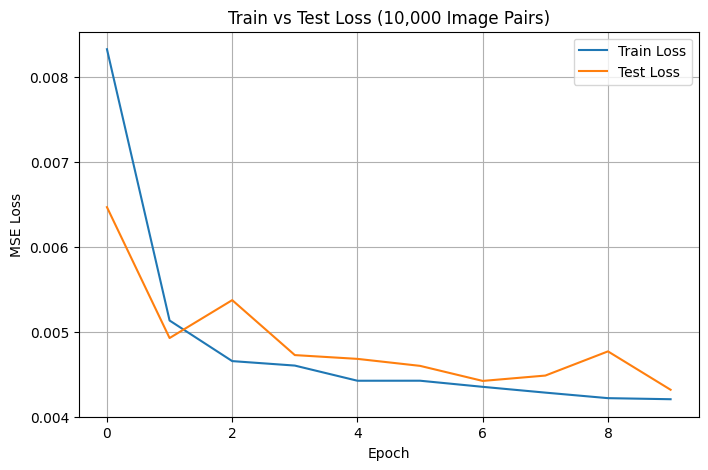

In [56]:
# Loss curve for model trained on limited dataset (10000 patches)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Test Loss (10,000 Image Pairs)")
plt.legend()
plt.grid()
#plt.savefig("loss_plot.png")
plt.show()

GT Mean Range: -0.13131655752658844 - 0.7000644207000732
GT Std Range: 0.02434184029698372 - 0.3697011470794678
MAE (Mean): 0.0430, RMSE (Mean): 0.0628
MAE (Std): 0.0145, RMSE (Std): 0.0224


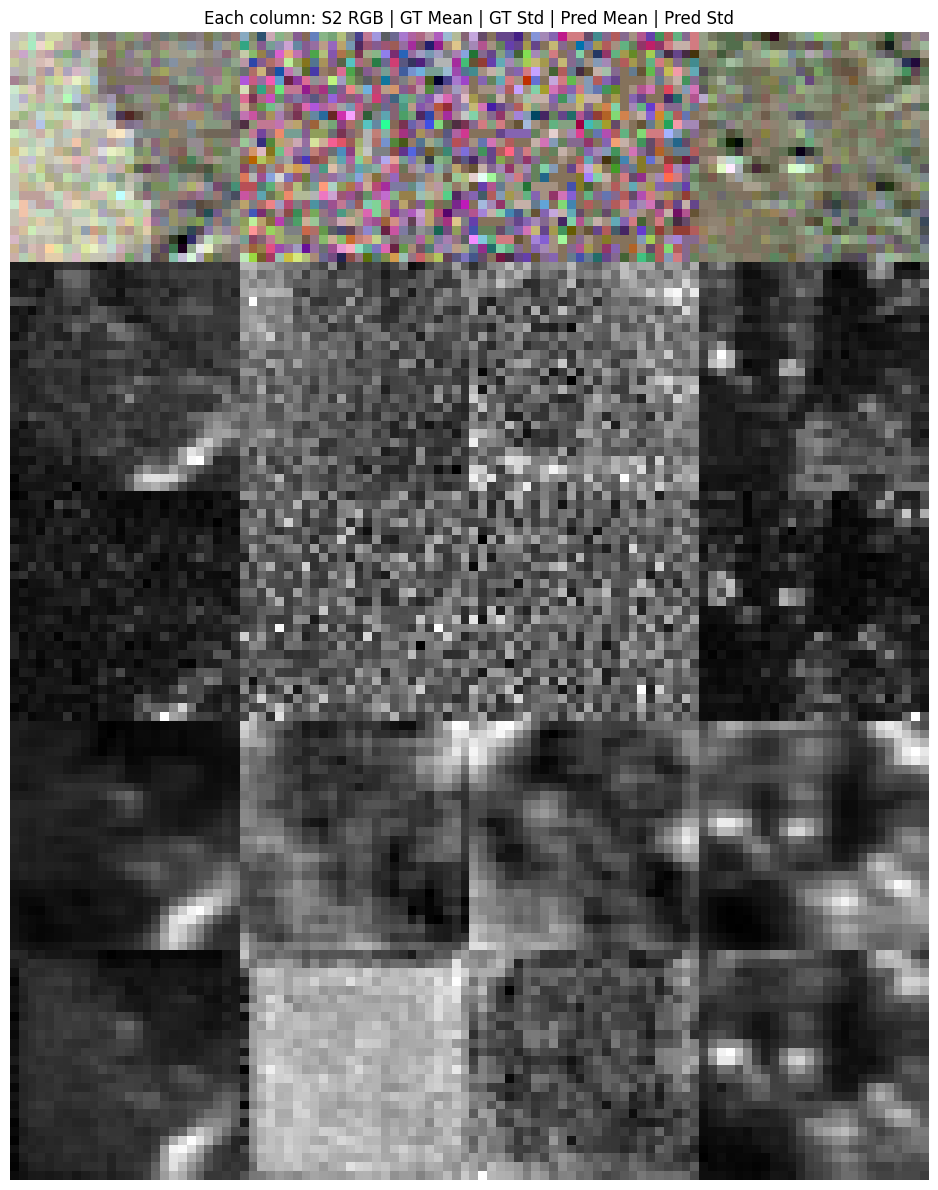

In [ ]:
def rescale_batch_channelwise(x):
    # x is (B, C, H, W)
    B, C, H, W = x.shape
    x_reshaped = x.view(B, C, -1)
    vmin = x_reshaped.min(dim=2, keepdim=True).values
    vmax = x_reshaped.max(dim=2, keepdim=True).values
    x_scaled = (x_reshaped - vmin) / (vmax - vmin + 1e-8)
    return x_scaled.view(B, C, H, W)


# Sample and visualize
model.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    s2 = batch["s2"].to(config["device"])
    lidar = batch["lidar"].to(config["device"])

    generated = p_sample_loop(model, scheduler, shape=lidar.shape, cond=s2, device=config["device"])

    s2_vis = rescale_batch_channelwise(s2[:4, :3].cpu())  # RGB only
    gt_mean = lidar[:4, 0:1].cpu()
    gt_std = lidar[:4, 1:2].cpu()
    pred_mean = generated[:4, 0:1].cpu()
    pred_std = generated[:4, 1:2].cpu()

    gt_mean_vis = rescale_batch_channelwise(gt_mean)
    gt_std_vis = rescale_batch_channelwise(gt_std)
    pred_mean_vis = rescale_batch_channelwise(pred_mean)
    pred_std_vis = rescale_batch_channelwise(pred_std)

    # Metrics
    #Print range of ground truths
    print(f"GT Mean Range: {gt_mean.min().item()} - {gt_mean.max().item()}")
    print(f"GT Std Range: {gt_std.min().item()} - {gt_std.max().item()}")
    mae_mean = F.l1_loss(pred_mean, gt_mean).item()
    rmse_mean = F.mse_loss(pred_mean, gt_mean).sqrt().item()
    mae_std = F.l1_loss(pred_std, gt_std).item()
    rmse_std = F.mse_loss(pred_std, gt_std).sqrt().item()

    print(f"MAE (Mean): {mae_mean:.4f}, RMSE (Mean): {rmse_mean:.4f}")
    print(f"MAE (Std): {mae_std:.4f}, RMSE (Std): {rmse_std:.4f}")

    # Create a visualization grid for each sample: S2 RGB | GT Mean | GT Std | Pred Mean | Pred Std
    vis_list = []
    for i in range(4):
        stacked = torch.cat([
            s2_vis[i],
            gt_mean_vis[i].repeat(3, 1, 1),
            gt_std_vis[i].repeat(3, 1, 1),
            pred_mean_vis[i].repeat(3, 1, 1),
            pred_std_vis[i].repeat(3, 1, 1)
        ], dim=1)
        vis_list.append(stacked)

    final_grid = torch.cat(vis_list, dim=2)
    plt.figure(figsize=(20, 12))
    plt.imshow(final_grid.permute(1, 2, 0).numpy())
    plt.title("Each column: S2 RGB | GT Mean | GT Std | Pred Mean | Pred Std")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


GT Mean Range: -0.13131655752658844 - 0.7000644207000732
GT Std Range: 0.0 - 0.3697011470794678
Normalized RMSE: 6.80%
MAE (Mean): 0.0404, RMSE (Mean): 0.0565
MAE (Std): 0.0177, RMSE (Std): 0.0247


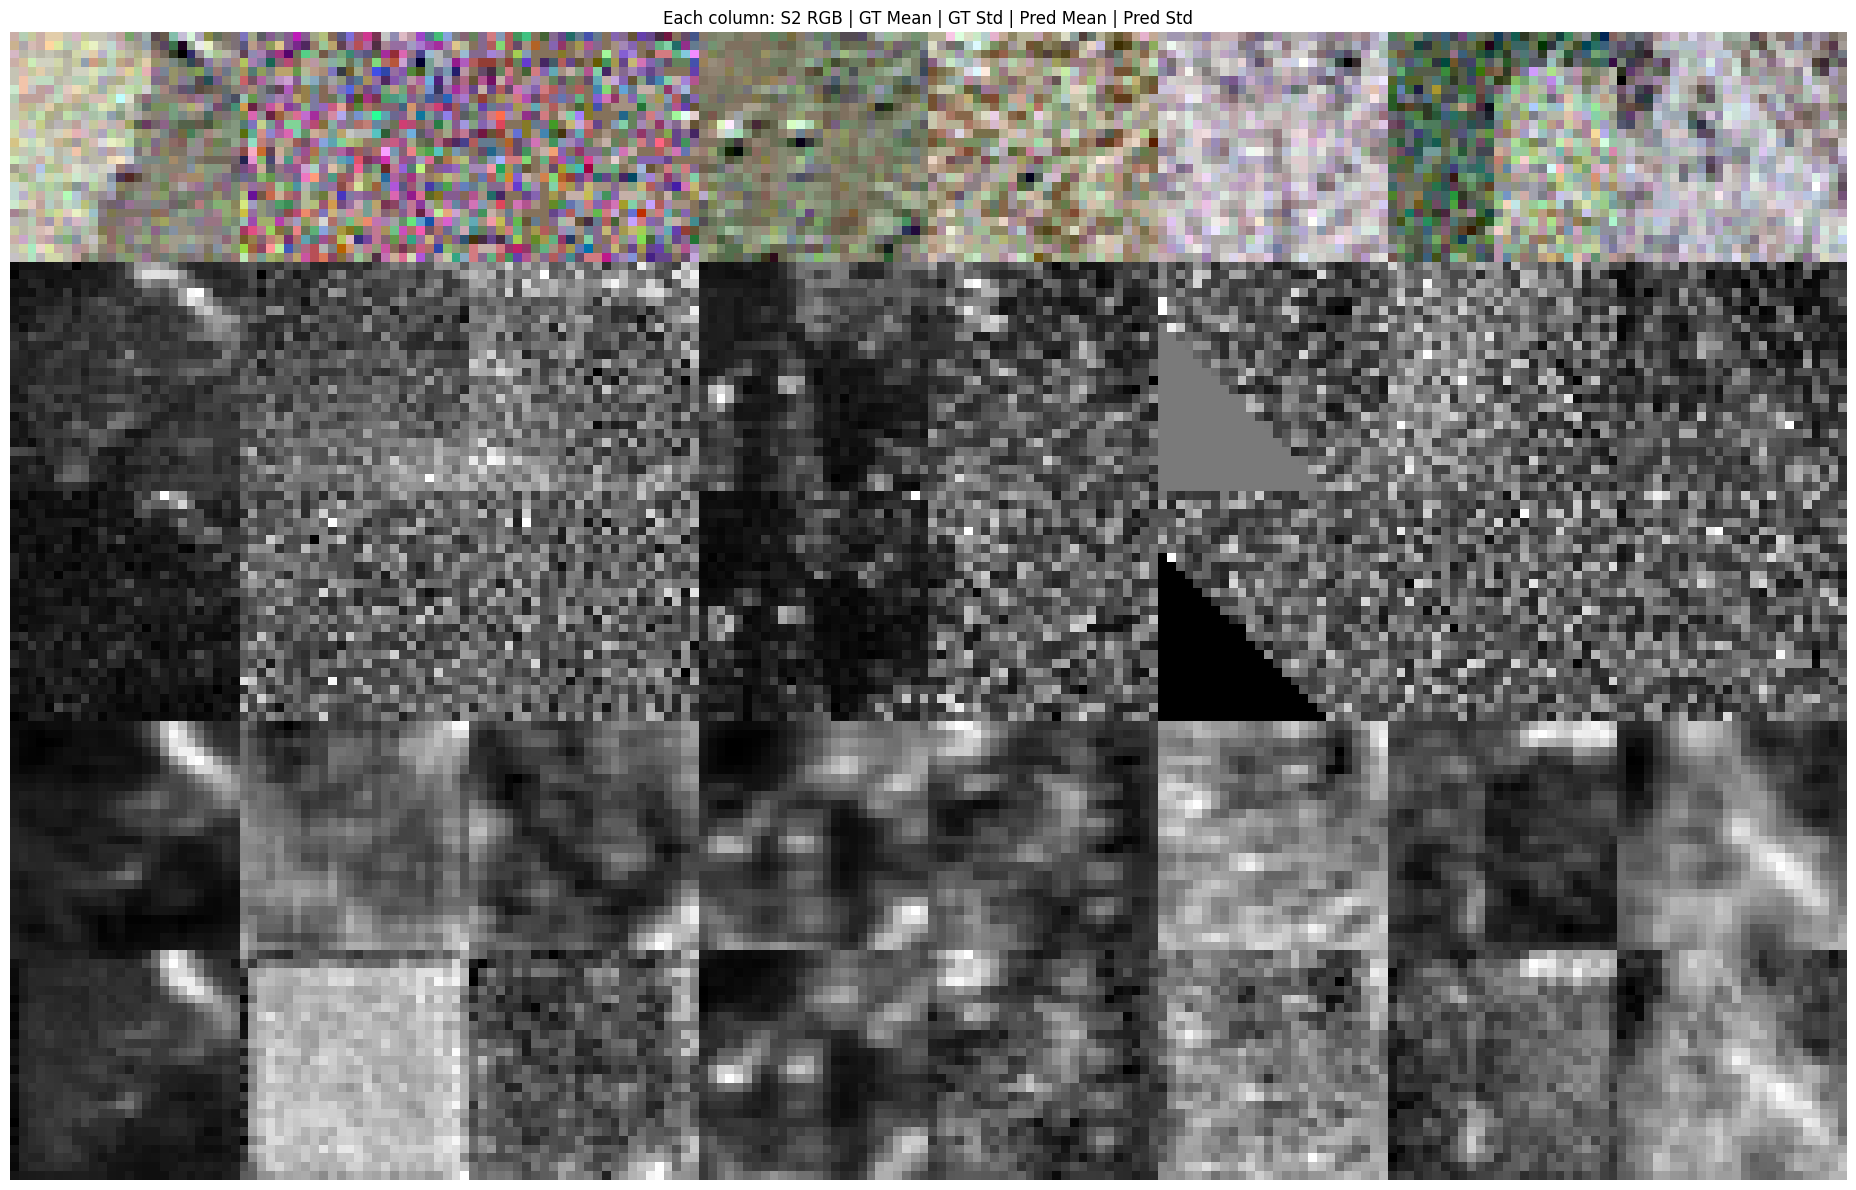

In [75]:
# Sample and visualize
model.eval()
with torch.no_grad():
    # get new batch
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    batch = next(iter(test_loader))
    s2 = batch["s2"].to(config["device"])
    lidar = batch["lidar"].to(config["device"])

    generated = p_sample_loop_ddpm(model, scheduler, shape=lidar.shape, cond=s2, device=config["device"])

    s2_vis = rescale_batch_channelwise(s2[:8, :3].cpu())  # RGB only
    gt_mean = lidar[:8, 0:1].cpu()
    gt_std = lidar[:8, 1:2].cpu()
    pred_mean = generated[:8, 0:1].cpu()
    pred_std = generated[:8, 1:2].cpu()

    gt_mean_vis = rescale_batch_channelwise(gt_mean)
    gt_std_vis = rescale_batch_channelwise(gt_std)
    pred_mean_vis = rescale_batch_channelwise(pred_mean)
    pred_std_vis = rescale_batch_channelwise(pred_std)

    # Metrics
    print(f"GT Mean Range: {gt_mean.min().item()} - {gt_mean.max().item()}")
    print(f"GT Std Range: {gt_std.min().item()} - {gt_std.max().item()}")
    mae_mean = F.l1_loss(pred_mean, gt_mean).item()
    rmse_mean = F.mse_loss(pred_mean, gt_mean).sqrt().item()
    mae_std = F.l1_loss(pred_std, gt_std).item()
    rmse_std = F.mse_loss(pred_std, gt_std).sqrt().item()

    # Normalized RMSE
    rmse_std = F.mse_loss(pred_std, gt_std).sqrt().item()
    gt_np = gt_mean.numpy().flatten()
    pred_np = pred_mean.numpy().flatten()
    rmse_val = np.sqrt(np.mean((gt_np - pred_np)**2))

    value_range = gt_np.max() - gt_np.min()
    nrmse = (rmse_val / value_range) * 100
    print(f"Normalized RMSE: {nrmse:.2f}%")

    print(f"MAE (Mean): {mae_mean:.4f}, RMSE (Mean): {rmse_mean:.4f}")
    print(f"MAE (Std): {mae_std:.4f}, RMSE (Std): {rmse_std:.4f}")

    # Create a visualization grid for each sample: S2 RGB | GT Mean | GT Std | Pred Mean | Pred Std
    vis_list = []
    for i in range(8):
        stacked = torch.cat([
            s2_vis[i],
            gt_mean_vis[i].repeat(3, 1, 1),
            gt_std_vis[i].repeat(3, 1, 1),
            pred_mean_vis[i].repeat(3, 1, 1),
            pred_std_vis[i].repeat(3, 1, 1)
        ], dim=1)
        vis_list.append(stacked)

    final_grid = torch.cat(vis_list, dim=2)
    plt.figure(figsize=(40, 12))
    plt.imshow(final_grid.permute(1, 2, 0).numpy())
    plt.title("Each column: S2 RGB | GT Mean | GT Std | Pred Mean | Pred Std")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


GT Mean Range: -0.1475793421268463 - 1.1930384635925293
GT Std Range: 0.0 - 0.48985108733177185
MAE (Mean): 0.0536, RMSE (Mean): 0.0802
MAE (Std): 0.0215, RMSE (Std): 0.0325


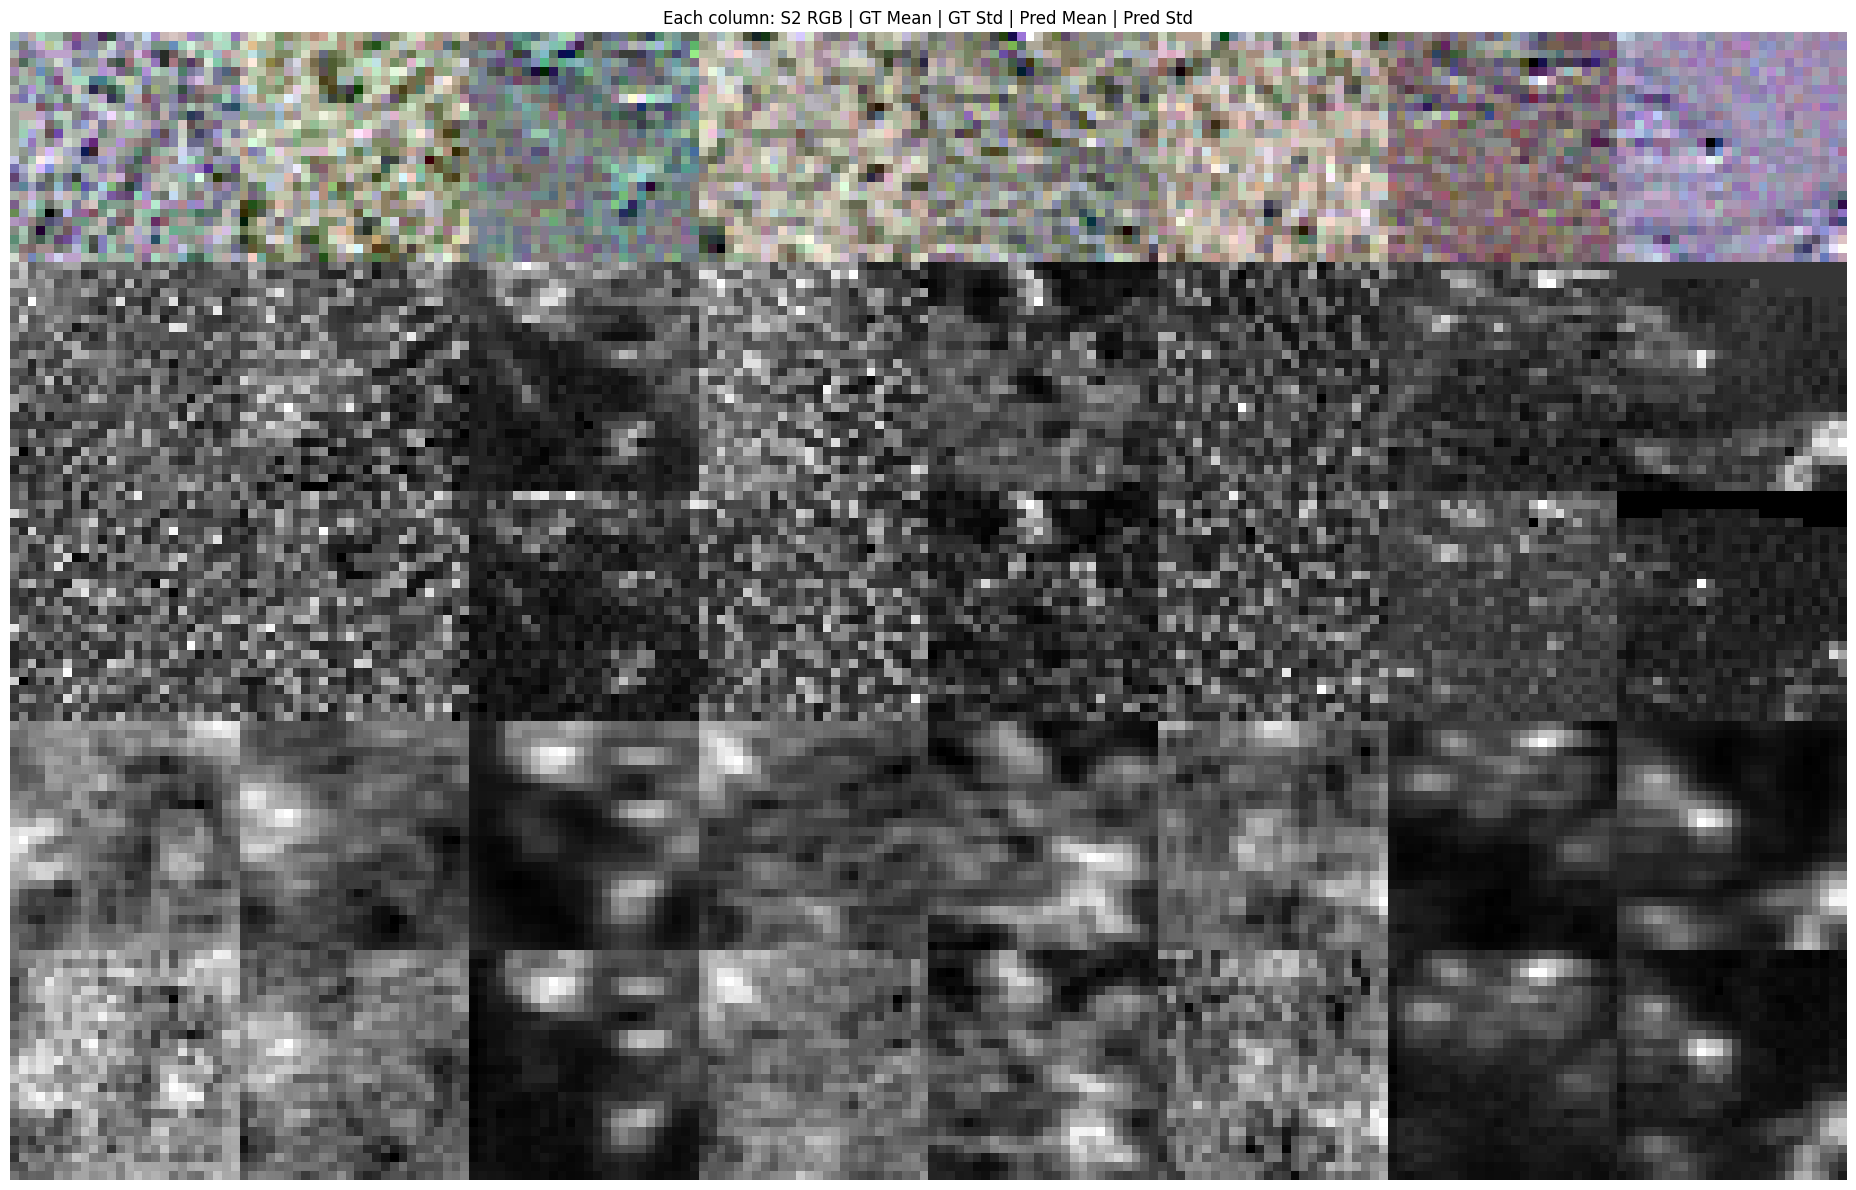

In [71]:
# Sample and visualize
model.eval()
with torch.no_grad():
    # get new batch
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
    batch = next(iter(test_loader))
    s2 = batch["s2"].to(config["device"])
    lidar = batch["lidar"].to(config["device"])

    generated = p_sample_loop_ddim(model, scheduler, shape=lidar.shape, cond=s2, device=config["device"])

    s2_vis = rescale_batch_channelwise(s2[:8, :3].cpu())  # RGB only
    gt_mean = lidar[:8, 0:1].cpu()
    gt_std = lidar[:8, 1:2].cpu()
    pred_mean = generated[:8, 0:1].cpu()
    pred_std = generated[:8, 1:2].cpu()

    gt_mean_vis = rescale_batch_channelwise(gt_mean)
    gt_std_vis = rescale_batch_channelwise(gt_std)
    pred_mean_vis = rescale_batch_channelwise(pred_mean)
    pred_std_vis = rescale_batch_channelwise(pred_std)

    # Metrics
    print(f"GT Mean Range: {gt_mean.min().item()} - {gt_mean.max().item()}")
    print(f"GT Std Range: {gt_std.min().item()} - {gt_std.max().item()}")
    mae_mean = F.l1_loss(pred_mean, gt_mean).item()
    rmse_mean = F.mse_loss(pred_mean, gt_mean).sqrt().item()
    mae_std = F.l1_loss(pred_std, gt_std).item()
    rmse_std = F.mse_loss(pred_std, gt_std).sqrt().item()

    print(f"MAE (Mean): {mae_mean:.4f}, RMSE (Mean): {rmse_mean:.4f}")
    print(f"MAE (Std): {mae_std:.4f}, RMSE (Std): {rmse_std:.4f}")

    # Create a visualization grid for each sample: S2 RGB | GT Mean | GT Std | Pred Mean | Pred Std
    vis_list = []
    for i in range(8):
        stacked = torch.cat([
            s2_vis[i],
            gt_mean_vis[i].repeat(3, 1, 1),
            gt_std_vis[i].repeat(3, 1, 1),
            pred_mean_vis[i].repeat(3, 1, 1),
            pred_std_vis[i].repeat(3, 1, 1)
        ], dim=1)
        vis_list.append(stacked)

    final_grid = torch.cat(vis_list, dim=2)
    plt.figure(figsize=(40, 12))
    plt.imshow(final_grid.permute(1, 2, 0).numpy())
    plt.title("Each column: S2 RGB | GT Mean | GT Std | Pred Mean | Pred Std")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


GT Mean Range: -0.13217748701572418 - 0.7474241852760315
GT Std Range: 0.008821774274110794 - 0.3877858519554138
MAE (Mean): 0.0418, RMSE (Mean): 0.0614
MAE (Std): 0.0163, RMSE (Std): 0.0228


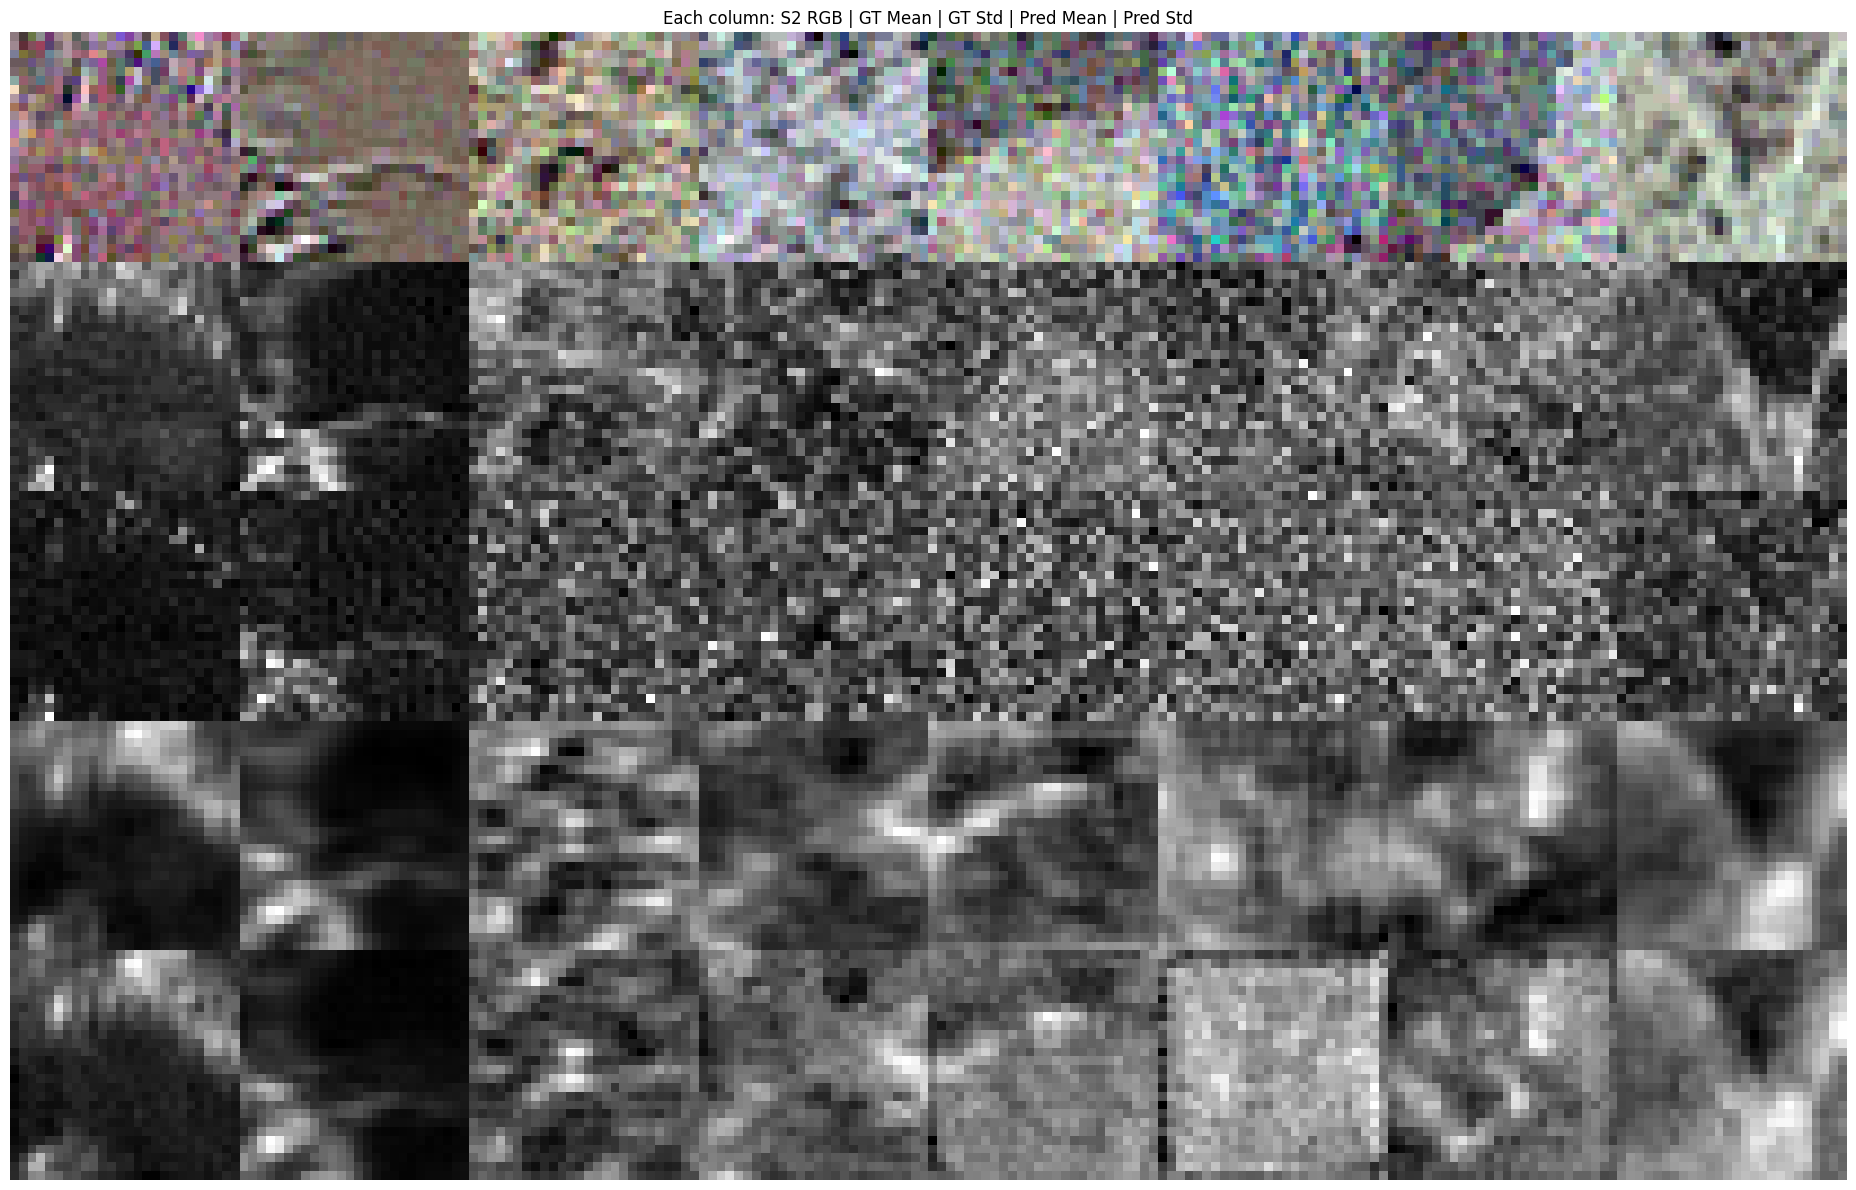

In [70]:
# Sample and visualize
model.eval()
with torch.no_grad():
    # get new batch
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
    batch = next(iter(test_loader))
    s2 = batch["s2"].to(config["device"])
    lidar = batch["lidar"].to(config["device"])

    generated = p_sample_loop_plms(model, scheduler, shape=lidar.shape, cond=s2, device=config["device"])

    s2_vis = rescale_batch_channelwise(s2[:8, :3].cpu())  # RGB only
    gt_mean = lidar[:8, 0:1].cpu()
    gt_std = lidar[:8, 1:2].cpu()
    pred_mean = generated[:8, 0:1].cpu()
    pred_std = generated[:8, 1:2].cpu()

    gt_mean_vis = rescale_batch_channelwise(gt_mean)
    gt_std_vis = rescale_batch_channelwise(gt_std)
    pred_mean_vis = rescale_batch_channelwise(pred_mean)
    pred_std_vis = rescale_batch_channelwise(pred_std)

    # Metrics
    print(f"GT Mean Range: {gt_mean.min().item()} - {gt_mean.max().item()}")
    print(f"GT Std Range: {gt_std.min().item()} - {gt_std.max().item()}")
    mae_mean = F.l1_loss(pred_mean, gt_mean).item()
    rmse_mean = F.mse_loss(pred_mean, gt_mean).sqrt().item()
    mae_std = F.l1_loss(pred_std, gt_std).item()
    rmse_std = F.mse_loss(pred_std, gt_std).sqrt().item()

    print(f"MAE (Mean): {mae_mean:.4f}, RMSE (Mean): {rmse_mean:.4f}")
    print(f"MAE (Std): {mae_std:.4f}, RMSE (Std): {rmse_std:.4f}")

    # Create a visualization grid for each sample: S2 RGB | GT Mean | GT Std | Pred Mean | Pred Std
    vis_list = []
    for i in range(8):
        stacked = torch.cat([
            s2_vis[i],
            gt_mean_vis[i].repeat(3, 1, 1),
            gt_std_vis[i].repeat(3, 1, 1),
            pred_mean_vis[i].repeat(3, 1, 1),
            pred_std_vis[i].repeat(3, 1, 1)
        ], dim=1)
        vis_list.append(stacked)

    final_grid = torch.cat(vis_list, dim=2)
    plt.figure(figsize=(40, 12))
    plt.imshow(final_grid.permute(1, 2, 0).numpy())
    plt.title("Each column: S2 RGB | GT Mean | GT Std | Pred Mean | Pred Std")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


GT Mean Range: -0.13131655752658844 - 0.7000644207000732
GT Std Range: 0.0 - 0.3697011470794678
Normalized RMSE: 6.80%
MAE (Mean): 0.0405, RMSE (Mean): 0.0565
MAE (Std): 0.0178, RMSE (Std): 0.0248


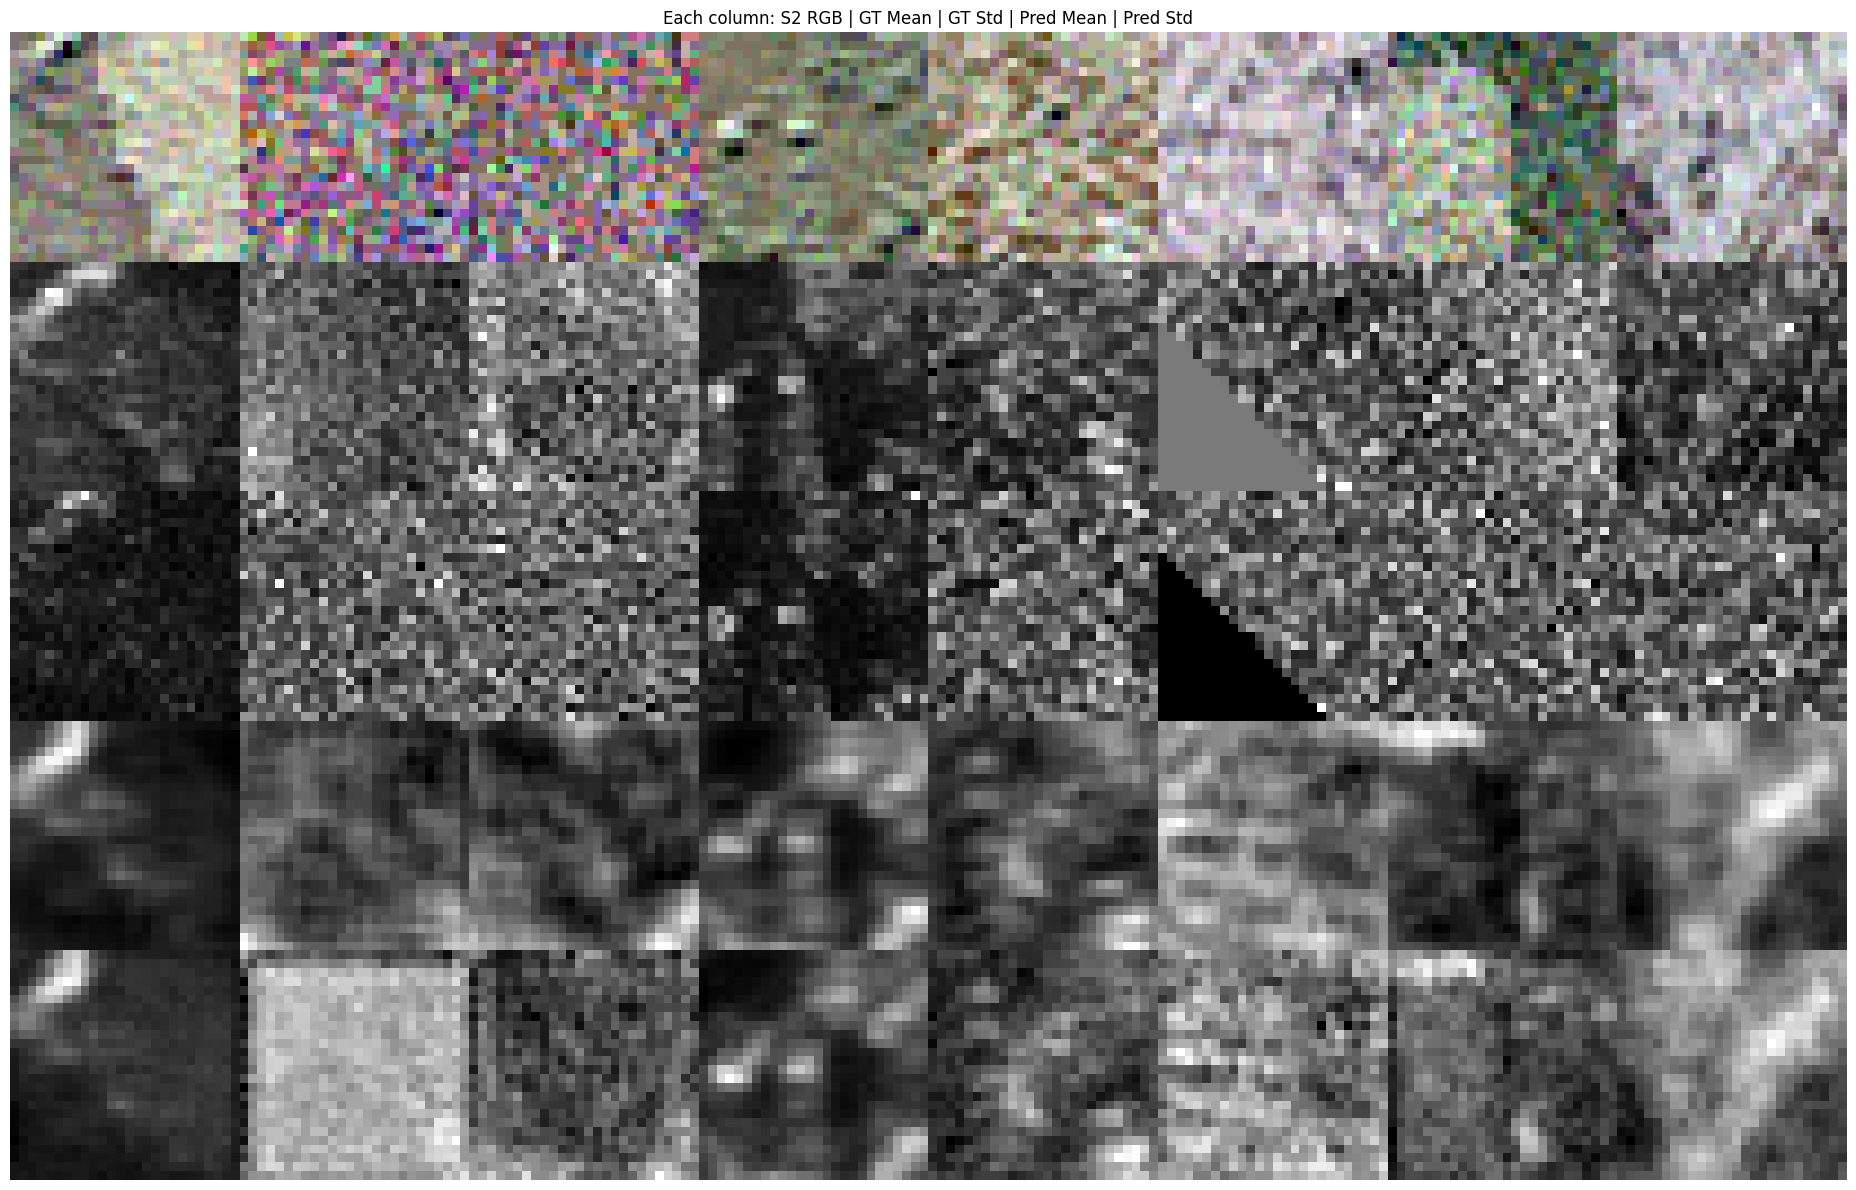

In [76]:
# Sample and visualize
model.eval()
with torch.no_grad():
    # get new batch
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    batch = next(iter(test_loader))
    s2 = batch["s2"].to(config["device"])
    lidar = batch["lidar"].to(config["device"])

    generated = p_sample_loop_ddim(model, scheduler, shape=lidar.shape, cond=s2, device=config["device"])

    s2_vis = rescale_batch_channelwise(s2[:8, :3].cpu())  # RGB only
    gt_mean = lidar[:8, 0:1].cpu()
    gt_std = lidar[:8, 1:2].cpu()
    pred_mean = generated[:8, 0:1].cpu()
    pred_std = generated[:8, 1:2].cpu()

    gt_mean_vis = rescale_batch_channelwise(gt_mean)
    gt_std_vis = rescale_batch_channelwise(gt_std)
    pred_mean_vis = rescale_batch_channelwise(pred_mean)
    pred_std_vis = rescale_batch_channelwise(pred_std)

    # Metrics
    print(f"GT Mean Range: {gt_mean.min().item()} - {gt_mean.max().item()}")
    print(f"GT Std Range: {gt_std.min().item()} - {gt_std.max().item()}")
    mae_mean = F.l1_loss(pred_mean, gt_mean).item()
    rmse_mean = F.mse_loss(pred_mean, gt_mean).sqrt().item()
    mae_std = F.l1_loss(pred_std, gt_std).item()
    rmse_std = F.mse_loss(pred_std, gt_std).sqrt().item()

     # Normalized RMSE
    rmse_std = F.mse_loss(pred_std, gt_std).sqrt().item()
    gt_np = gt_mean.numpy().flatten()
    pred_np = pred_mean.numpy().flatten()
    rmse_val = np.sqrt(np.mean((gt_np - pred_np)**2))

    value_range = gt_np.max() - gt_np.min()
    nrmse = (rmse_val / value_range) * 100
    print(f"Normalized RMSE: {nrmse:.2f}%")

    print(f"MAE (Mean): {mae_mean:.4f}, RMSE (Mean): {rmse_mean:.4f}")
    print(f"MAE (Std): {mae_std:.4f}, RMSE (Std): {rmse_std:.4f}")

    # Create a visualization grid for each sample: S2 RGB | GT Mean | GT Std | Pred Mean | Pred Std
    vis_list = []
    for i in range(8):
        stacked = torch.cat([
            s2_vis[i],
            gt_mean_vis[i].repeat(3, 1, 1),
            gt_std_vis[i].repeat(3, 1, 1),
            pred_mean_vis[i].repeat(3, 1, 1),
            pred_std_vis[i].repeat(3, 1, 1)
        ], dim=1)
        vis_list.append(stacked)

    final_grid = torch.cat(vis_list, dim=2)
    plt.figure(figsize=(40, 12))
    plt.imshow(final_grid.permute(1, 2, 0).numpy())
    plt.title("Each column: S2 RGB | GT Mean | GT Std | Pred Mean | Pred Std")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


GT Mean Range: -0.13131655752658844 - 0.7000644207000732
GT Std Range: 0.0 - 0.3697011470794678
Normalized RMSE: 6.72%
MAE (Mean): 0.0401, RMSE (Mean): 0.0559
MAE (Std): 0.0178, RMSE (Std): 0.0248


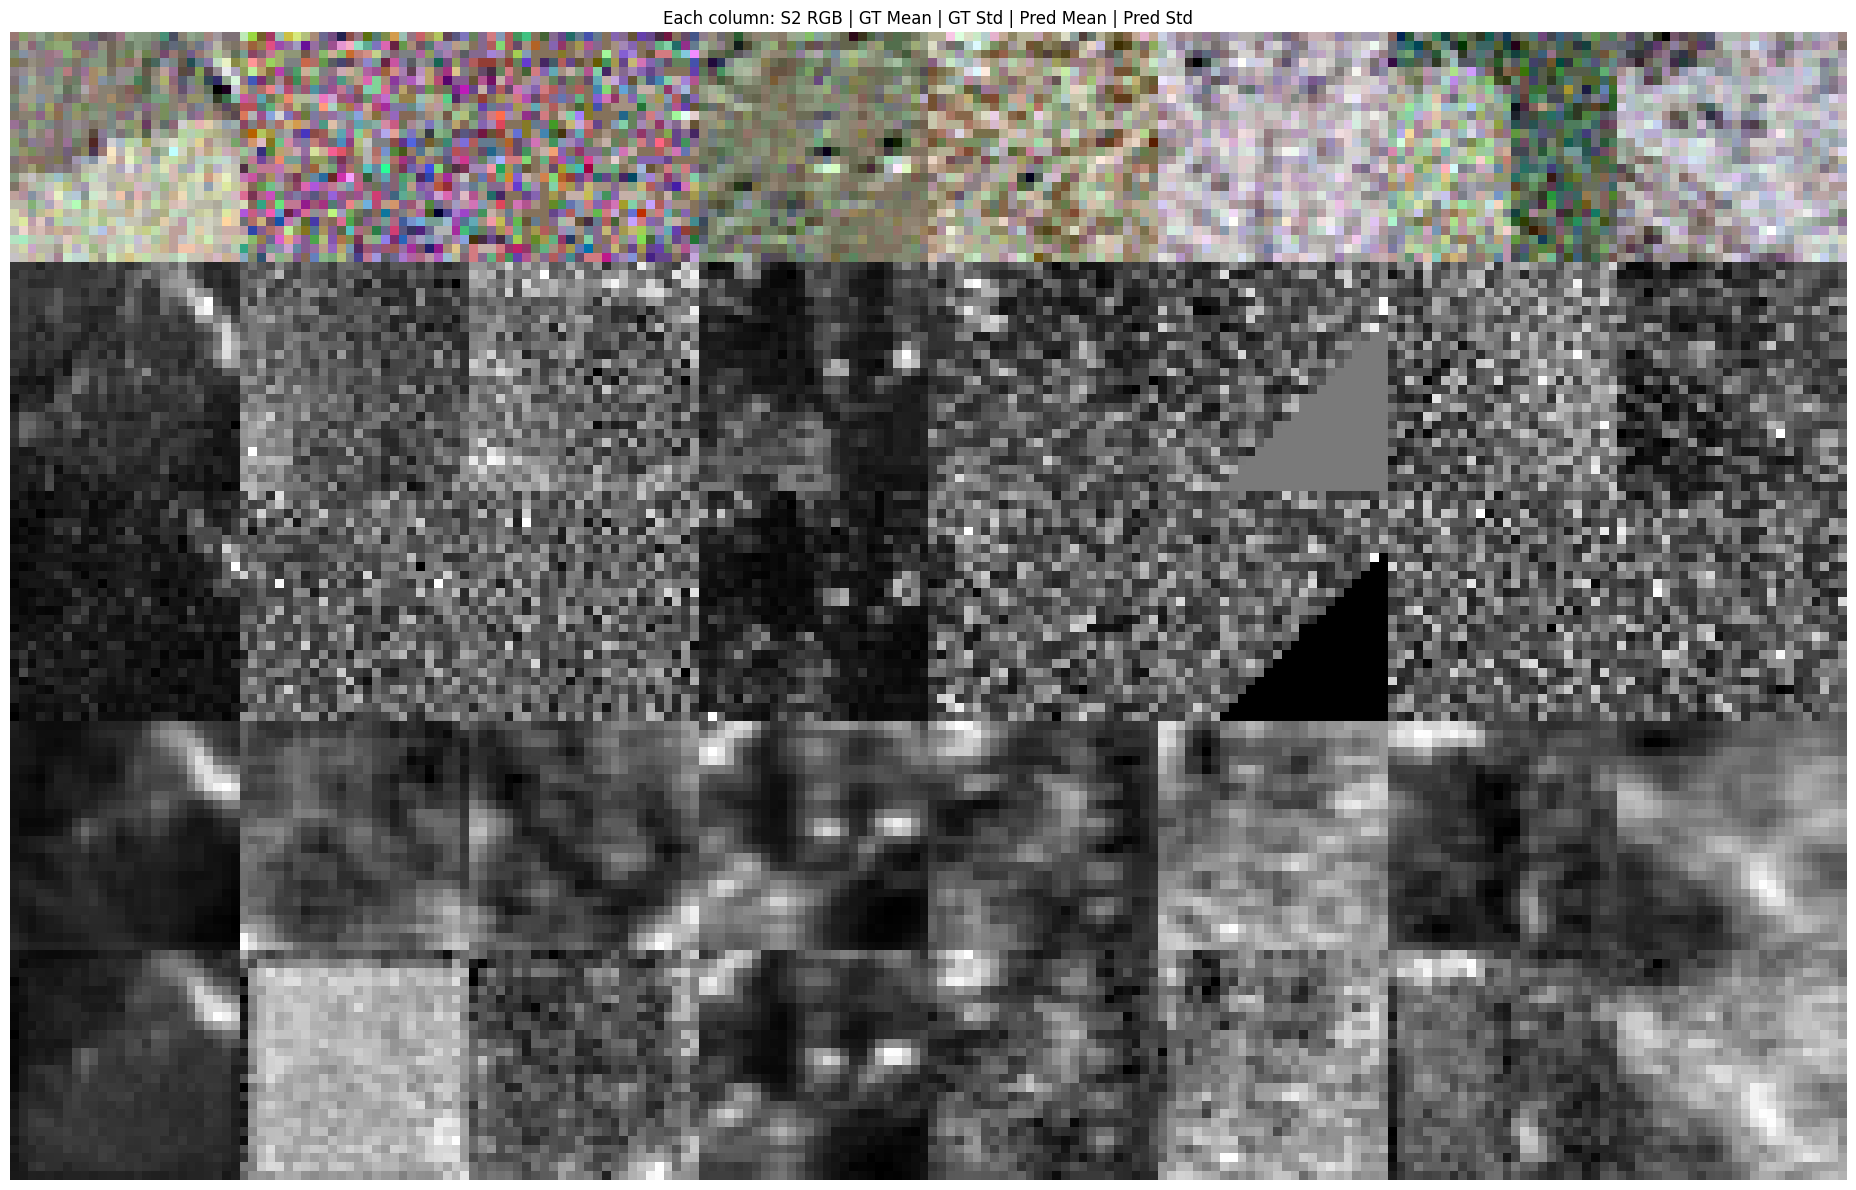

In [74]:
# Sample and visualize
model.eval()
with torch.no_grad():
    # get new batch
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    batch = next(iter(test_loader))
    s2 = batch["s2"].to(config["device"])
    lidar = batch["lidar"].to(config["device"])

    generated = p_sample_loop_plms(model, scheduler, shape=lidar.shape, cond=s2, device=config["device"])

    s2_vis = rescale_batch_channelwise(s2[:8, :3].cpu())  # RGB only
    gt_mean = lidar[:8, 0:1].cpu()
    gt_std = lidar[:8, 1:2].cpu()
    pred_mean = generated[:8, 0:1].cpu()
    pred_std = generated[:8, 1:2].cpu()

    gt_mean_vis = rescale_batch_channelwise(gt_mean)
    gt_std_vis = rescale_batch_channelwise(gt_std)
    pred_mean_vis = rescale_batch_channelwise(pred_mean)
    pred_std_vis = rescale_batch_channelwise(pred_std)

    # Metrics
    print(f"GT Mean Range: {gt_mean.min().item()} - {gt_mean.max().item()}")
    print(f"GT Std Range: {gt_std.min().item()} - {gt_std.max().item()}")
    mae_mean = F.l1_loss(pred_mean, gt_mean).item()
    rmse_mean = F.mse_loss(pred_mean, gt_mean).sqrt().item()
    mae_std = F.l1_loss(pred_std, gt_std).item()

    # Normalized RMSE
    rmse_std = F.mse_loss(pred_std, gt_std).sqrt().item()
    gt_np = gt_mean.numpy().flatten()
    pred_np = pred_mean.numpy().flatten()
    rmse_val = np.sqrt(np.mean((gt_np - pred_np)**2))

    value_range = gt_np.max() - gt_np.min()
    nrmse = (rmse_val / value_range) * 100
    print(f"Normalized RMSE: {nrmse:.2f}%")


    print(f"MAE (Mean): {mae_mean:.4f}, RMSE (Mean): {rmse_mean:.4f}")
    print(f"MAE (Std): {mae_std:.4f}, RMSE (Std): {rmse_std:.4f}")

    # Create a visualization grid for each sample: S2 RGB | GT Mean | GT Std | Pred Mean | Pred Std
    vis_list = []
    for i in range(8):
        stacked = torch.cat([
            s2_vis[i],
            gt_mean_vis[i].repeat(3, 1, 1),
            gt_std_vis[i].repeat(3, 1, 1),
            pred_mean_vis[i].repeat(3, 1, 1),
            pred_std_vis[i].repeat(3, 1, 1)
        ], dim=1)
        vis_list.append(stacked)

    final_grid = torch.cat(vis_list, dim=2)
    plt.figure(figsize=(40, 12))
    plt.imshow(final_grid.permute(1, 2, 0).numpy())
    plt.title("Each column: S2 RGB | GT Mean | GT Std | Pred Mean | Pred Std")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
# To do:

    # Structural Similarity Metrics
    # Figure out how im normalizing/standardizing both visually and for training (original question was why is the lidar so noisy?)
    # Get solar viewing angle from sentinel-2 and use it as input
    # Super-resolution task
    # Clean up code and upload to drive along with the data or a subset of the data
    # Weibin wants the training index for comparison

